In [1]:
%%capture
!pip install --upgrade azure-storage-blob
!pip install obspy

### DO NOT PROCEED. RESTART RUNTIME NOW! https://github.com/obspy/obspy/issues/2547#issuecomment-583123449

# Setup for Azure

In [2]:
from getpass import getpass
account_name = 'nanometricstransfer'
account_key = getpass('Key: ')

Key: ········


In [1]:
from azure.storage.blob import BlobServiceClient, BlobClient

In [2]:
# Source: https://www.quickprogrammingtips.com/azure/how-to-download-blobs-from-azure-storage-using-python.html

import os
import re
from azure.storage.blob import BlobServiceClient, BlobClient
from azure.storage.blob import ContentSettings, ContainerClient
 
# IMPORTANT: Replace connection string with your storage account connection string
# Usually starts with DefaultEndpointsProtocol=https;...
MY_CONNECTION_STRING = "DefaultEndpointsProtocol=https;AccountName=%s;AccountKey=%s" % (account_name, account_key)
 
# Replace with blob container
MY_BLOB_CONTAINER = "nanometricstransfer"
 
class AzureBlobFileDownloader:
    def __init__(self):
        print("Intializing AzureBlobFileDownloader")
        # Initialize the connection to Azure storage account
        self.blob_service_client =  BlobServiceClient.from_connection_string(MY_CONNECTION_STRING)
        self.my_container = self.blob_service_client.get_container_client(MY_BLOB_CONTAINER)

    def save_blob(self, file_name, file_content):
        os.makedirs(os.path.dirname(file_name), exist_ok=True)
        with open(file_name, "wb") as f:
            f.write(file_content)

    def download(self, datetag, channel_tag=None):
        prefix = os.path.join('seed_files', datetag, 'EY.CH')
        all_blobs = self.my_container.list_blobs(name_starts_with=prefix)
        outpaths = []
        for blob in all_blobs:
            if channel_tag and channel_tag not in blob.name: continue # Filter for nametag
            file_name = blob.name + '.mseed'
            if os.path.exists(file_name):
                print(file_name + " existed")
            else:
                bytes = self.my_container.get_blob_client(blob).download_blob().readall()
                self.save_blob(file_name, bytes)
                print(file_name + " downloaded")
            outpaths.append(file_name)
        return outpaths
 
# Initialize class and upload files
azure_blob_file_downloader = AzureBlobFileDownloader()
data_paths = azure_blob_file_downloader.download(datetag='2019-09/2019-09-10/', channel_tag='CH02A.00.HHZ')

NameError: name 'account_name' is not defined

Data process

In [2]:
import datetime
from datetime import date


def datefolder(input_str):
    yrmo = '-'.join(input_str.split('-')[0:2])
    datetag = yrmo+'/'+input_str+'/'
    return datetag
def str2datetime(input_str):
    input_list = input_str.split('-')
    yr = int(input_list[0])
    mon = int(input_list[1])
    day = int(input_list[2])
    d = date(yr, mon, day)
    return d

In [9]:
from obspy import read

geophone_name = 'CH02A.00.HHZ'
start_day = '2019-07-01'
end_day = '2019-12-01'

azure_blob_file_downloader = AzureBlobFileDownloader()
data_paths = azure_blob_file_downloader.download(datetag=datefolder(start_day), channel_tag=geophone_name)

time_day = str2datetime(start_day)
data = read(data_paths[0])
timespan = str2datetime(end_day) - str2datetime(start_day)
for i in range(timespan.days):
    time_day = time_day + datetime.timedelta(days=1)
    
    data_paths = azure_blob_file_downloader.download(datetag=datefolder(str(time_day)), channel_tag=geophone_name)
    data = data + read(data_paths[0])


NameError: name 'AzureBlobFileDownloader' is not defined

Alternative approach to import the data (data has been downloaded to local)

In [56]:
from obspy import read

data_path = '/Users/liyunan/OneDrive - Stanford/1.CS229/Project/seed_files/'
geophone_name = 'CH02A.00.HHZ'
start_day = '2018-01-01'
end_day = '2020-06-30'


time_day = str2datetime(start_day)
data = read(data_path + datefolder(str(time_day)) + 'EY.' + geophone_name + '.' + str(time_day.year) + '.' + str((time_day - str2datetime(str(time_day.year)+'-01-01')).days + 1) + '.mseed')
timespan = str2datetime(end_day) - str2datetime(start_day)
for i in range(timespan.days):
    time_day = time_day + datetime.timedelta(days=1)
    full_path = data_path + datefolder(str(time_day)) + 'EY.' + geophone_name + '.' + str(time_day.year) + '.' + str((time_day - str2datetime(str(time_day.year)+'-01-01')).days + 1) + '.mseed'
    data = data + read(full_path)


In [5]:
data

63 Trace(s) in Stream:

EY.CH02A.00.HHZ | 2019-09-01T00:00:00.000000Z - 2019-09-01T23:59:59.990000Z | 100.0 Hz, 8640000 samples
...
(61 other traces)
...
EY.CH02A.00.HHZ | 2019-11-01T00:00:00.000000Z - 2019-11-01T23:59:59.990000Z | 100.0 Hz, 8640000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

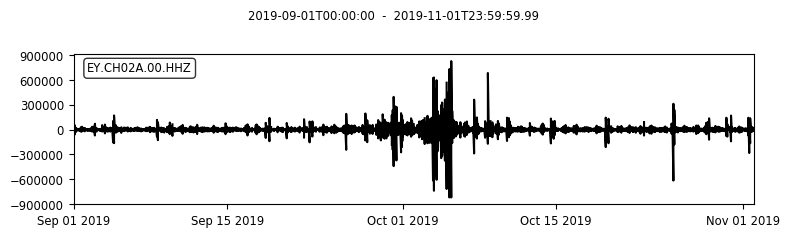

In [50]:
data.plot();


# K means

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn import cluster, covariance, manifold
from scipy.cluster.vq import kmeans2, vq, kmeans, whiten

## Time resolution: days

In [52]:
kmeans_input = np.asarray(data.std())
num_class = 2
#centroid, label = kmeans2(data, num_class, minit='points')
centroid, label = kmeans2(kmeans_input, num_class, minit='points')
print('The centroid of the two clusters are '+str(centroid[0])+' and '+str(centroid[1]))

The centroid of the two clusters are 5397.96289681 and 2824.08462883


Histogram is used as a error check for K-means clustering

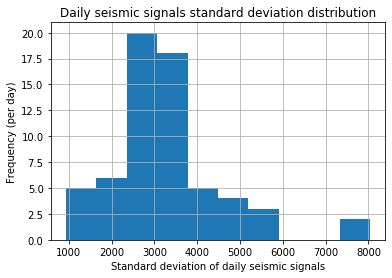

In [53]:
plt.hist(np.asarray(data.std()))
plt.xlabel('Standard deviation of daily seismic signals')
plt.ylabel('Frequency (per day)')
plt.title('Daily seismic signals standard deviation distribution')
plt.grid()
plt.show()

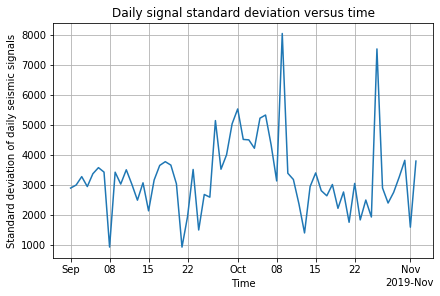

In [55]:
base = str2datetime(start_day)
dates = np.array([base + datetime.timedelta(days=(i)) for i in range(timespan.days+2)])

fig, ax = plt.subplots(constrained_layout=True)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(dates, kmeans_input)
ax.set_title('Daily signal standard deviation versus time')
plt.xlabel('Time')
plt.ylabel('Standard deviation of daily seismic signals')
plt.grid()
plt.show()

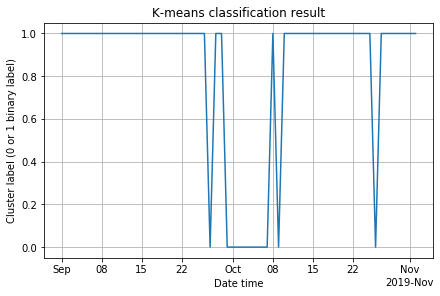

In [57]:
base = str2datetime(start_day)
dates = np.array([base + datetime.timedelta(days=(i)) for i in range(timespan.days+2)])

fig, ax = plt.subplots(constrained_layout=True)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(dates, label)
ax.set_title('K-means classification result')
plt.xlabel('Date time')
plt.ylabel('Cluster label (0 or 1 binary label)')
plt.grid()
plt.show()

## Time resolution: half a day

In [58]:
halfday_std = []
for i in range(len(data)):
    halfday_std.append(np.std(data[i].data[0:int(len(data[i].data)/2)]))
    halfday_std.append(np.std(data[i].data[int(len(data[i].data)/2):]))

In [59]:
kmeans_input = np.asarray(halfday_std)
num_class = 2
#centroid, label = kmeans2(data, num_class, minit='points')
centroid, label = kmeans2(kmeans_input, num_class, minit='points')
print('The centroid of the two clusters are '+str(centroid[0])+' and '+str(centroid[1]))

The centroid of the two clusters are 4520.43042339 and 1499.73072031


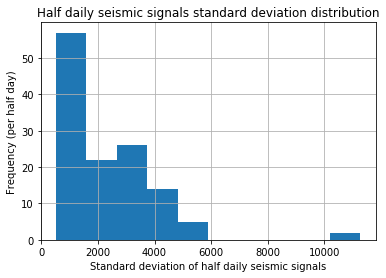

In [61]:
plt.hist(np.asarray(halfday_std))
plt.xlabel('Standard deviation of half daily seismic signals')
plt.ylabel('Frequency (per half day)')
plt.title('Half daily seismic signals standard deviation distribution')
plt.grid()
plt.show()

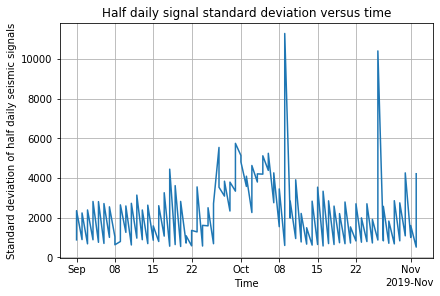

In [62]:
base = str2datetime(start_day)
dates = np.array([base + datetime.timedelta(days=(i/2)) for i in range(2*(timespan.days+2))])

fig, ax = plt.subplots(constrained_layout=True)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(dates, kmeans_input)
ax.set_title('Half daily signal standard deviation versus time')
plt.xlabel('Time')
plt.ylabel('Standard deviation of half daily seismic signals')
plt.grid()
plt.show()

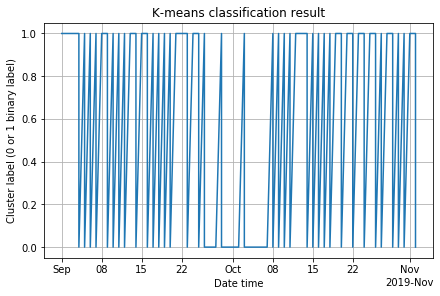

In [96]:
base = str2datetime(start_day)
dates = np.array([base + datetime.timedelta(days=(i/2)) for i in range(2*(timespan.days+2))])

fig, ax = plt.subplots(constrained_layout=True)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(dates, label)
ax.set_title('K-means classification result')
plt.xlabel('Date time')
plt.ylabel('Cluster label (0 or 1 binary label)')
plt.grid()
plt.show()

## Time resolution: 2 days

In [63]:
twoday_std = []
for i in range(int(len(data)/2)):
    d1 = data[2*i].data.tolist()
    d2 = data[2*i+1].data.tolist()
    twoday_std.append(np.std(d1+d2))

In [64]:
kmeans_input = np.asarray(twoday_std)
num_class = 2
#centroid, label = kmeans2(data, num_class, minit='points')
centroid, label = kmeans2(kmeans_input, num_class, minit='points')
print('The centroid of the two clusters are '+str(centroid[0])+' and '+str(centroid[1]))

The centroid of the two clusters are 2932.46488671 and 5085.15289244


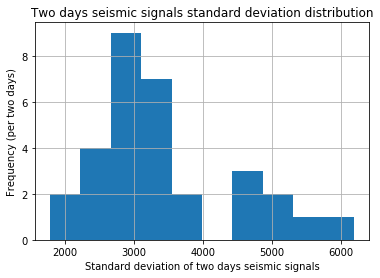

In [65]:
plt.hist(np.asarray(twoday_std))
plt.xlabel('Standard deviation of two days seismic signals')
plt.ylabel('Frequency (per two days)')
plt.title('Two days seismic signals standard deviation distribution')
plt.grid()
plt.show()

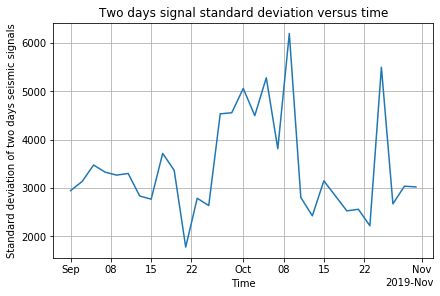

In [66]:
base = str2datetime(start_day)
dates = np.array([base + datetime.timedelta(days=(i*2)) for i in range(int((timespan.days+2)/2))])

fig, ax = plt.subplots(constrained_layout=True)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(dates, kmeans_input)
ax.set_title('Two days signal standard deviation versus time')
plt.xlabel('Time')
plt.ylabel('Standard deviation of two days seismic signals')
plt.grid()
plt.show()

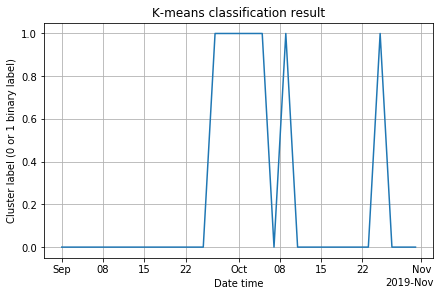

In [120]:
base = str2datetime(start_day)
dates = np.array([base + datetime.timedelta(days=(i*2)) for i in range(int((timespan.days+2)/2))])

fig, ax = plt.subplots(constrained_layout=True)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(dates, label)
ax.set_title('K-means classification result')
plt.xlabel('Date time')
plt.ylabel('Cluster label (0 or 1 binary label)')
plt.grid()
plt.show()

# Time series analysis

In [19]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api
from pandas.plotting import register_matplotlib_converters 
import numpy as np


In [50]:
base = str2datetime(start_day)
tsadata = np.asarray([])
for d in data:
    tsadata = np.concatenate((tsadata,d.data),axis=0)
    
dates_sec = np.array([base + datetime.timedelta(seconds=(i)) for i in range(24*3600*(timespan.days+1))])
decomposition = seasonal_decompose(tsadata,model='additive',freq=180, extrapolate_trend = 0)
#decomposition1 = seasonal_decompose(tsadata,model='additive',period=90, extrapolate_trend = 5)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

dates = np.array([base + datetime.timedelta(days=(i)) for i in range(timespan.days+1)])




/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  import sys


In [129]:
dates_sec = np.array([base + datetime.timedelta(seconds=(i/100)) for i in range(24*3600*100*(timespan.days+1))])



In [53]:
x = np.array([i+1 for i in range(len(trend))])/360000

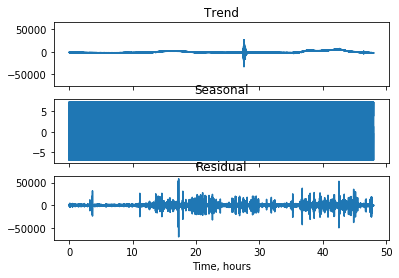

In [54]:

ax1 = plt.subplot(311)
plt.plot(x, trend)
plt.setp(ax1.get_xticklabels(), fontsize=6, visible=False)
plt.title('Trend')
# share x only
ax2 = plt.subplot(312, sharex=ax1)
plt.plot(x, seasonal)
# make these tick labels invisible
plt.setp(ax2.get_xticklabels(), visible=False)
plt.title('Seasonal')
# share x and y
ax3 = plt.subplot(313, sharex=ax1, sharey=ax1)
plt.plot(x, residual)
plt.title('Residual')
plt.xlabel('Time, hours')
#plt.xlim(0.01, 5.0)
plt.show()

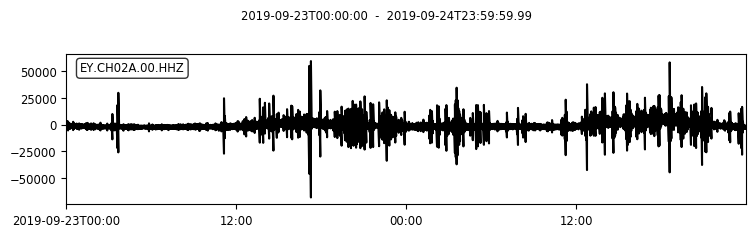

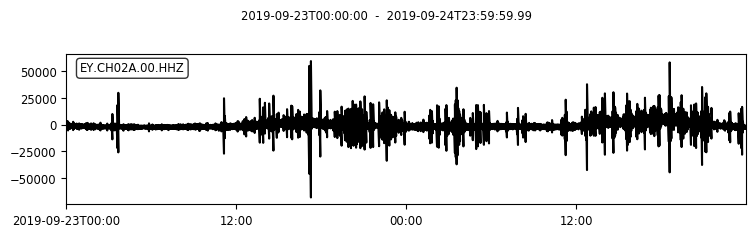

In [49]:
data.plot()

In [67]:
decomposition1 = seasonal_decompose(tsadata,model='additive',period=90, extrapolate_trend = 5)



In [70]:
decomposition1

# Analysis

In [5]:
from obspy import read
import matplotlib.pyplot as plt

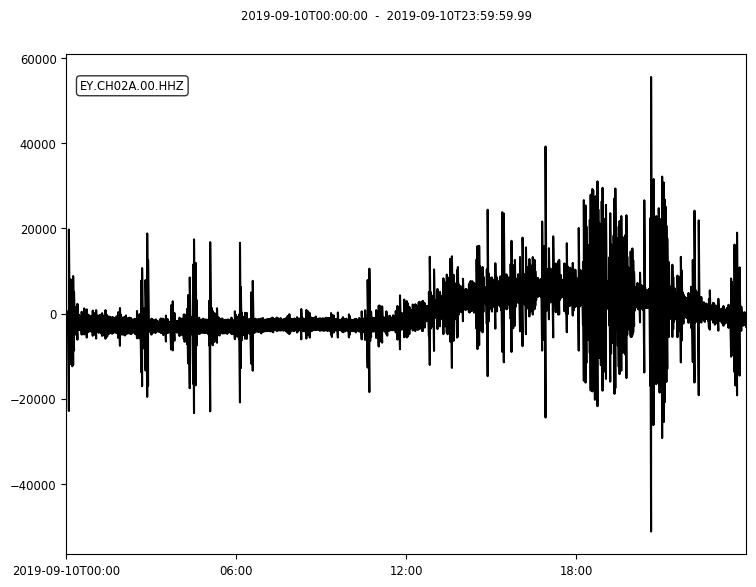

In [6]:
threechannels = read(data_paths[0])
for path in data_paths[1:]:
    threechannels += read(path)
threechannels.plot(size=(800, 600))
plt.show()

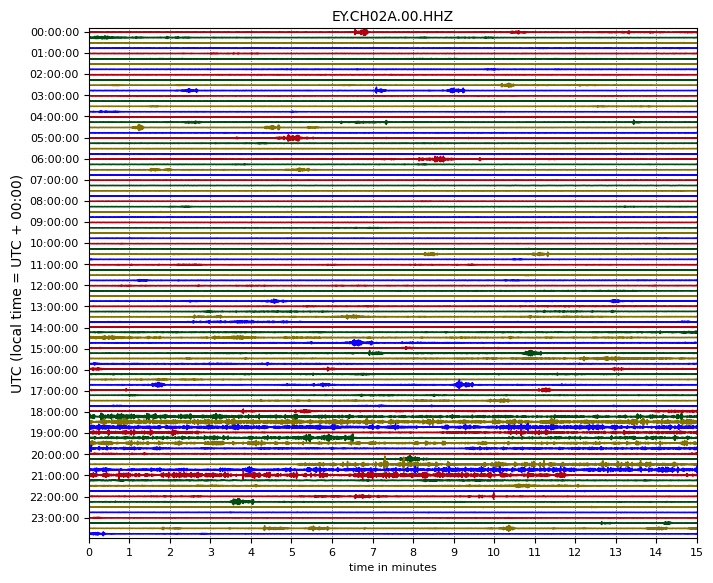

In [ ]:
singlechannel = threechannels[-1]
singlechannel.plot(type='dayplot', size=(800, 600))
plt.show()

/usr/local/lib/python3.6/dist-packages/obspy/imaging/waveform.py:511: UserWarning: Could not download the events because of 'FDSNException: Bad request. If you think your request was valid please contact the developers.
Detailed response of server:

Error 400: unknown : Cannot send body with 204
Request:
/fdsnws/event/1/query?starttime=2019-09-10T00%3A00%3A00.000000&endtime=2019-09-10T23%3A59%3A59.990000&minmagnitude=6.5
Request Submitted:
2020-10-15T15:40:20.950116Z
Service version:
fdsnws-event: v 1.1.0'.
  warnings.warn(msg)


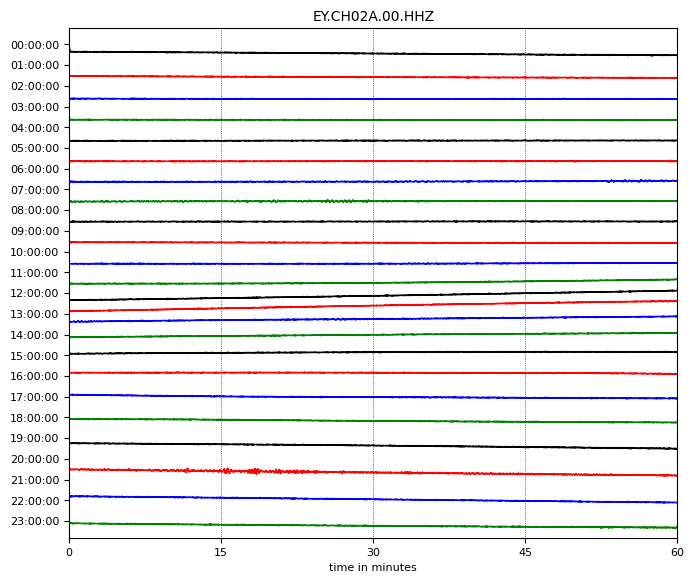

In [ ]:
singlechannel.filter("lowpass", freq=0.1, corners=2)
singlechannel.plot(type="dayplot", interval=60, right_vertical_labels=False,
         vertical_scaling_range=5e3, one_tick_per_line=True,
         color=['k', 'r', 'b', 'g'], show_y_UTC_label=False,
         events={'min_magnitude': 6.5})
plt.show()

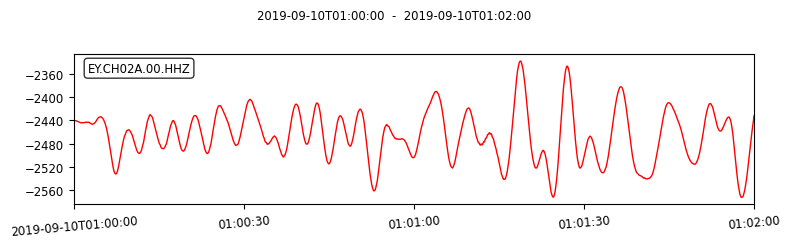

In [ ]:
dt = singlechannel.stats.starttime
singlechannel.plot(color='red', number_of_ticks=7,
                   tick_rotation=5, tick_format='%I:%M %p',
                   starttime=dt + 60*60, endtime=dt + 60*60 + 120)
plt.show()

# Part II: geospatial interpolation

In [147]:
import sys

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing

from pykrige.rk import RegressionKriging
from pykrige.compat import train_test_split

svr_model = SVR(C=0.1, gamma="auto")
rf_model = RandomForestRegressor(n_estimators=100)
lr_model = LinearRegression(normalize=True, copy_X=True, fit_intercept=False)

models = [svr_model, rf_model, lr_model]

p = np.array([dt[0].data.tolist(),dt[1].data.tolist(),dt[3].data.tolist()]).T
target = dt[2].data.reshape(len(dt[2].data),1)

for m in models:
    print("=" * 40)
    print("regression model:", m.__class__.__name__)
    m_rk = RegressionKriging(regression_model=m, n_closest_points=10)
    #m_rk.fit(p_train, x_train, target_train)
    #print("Regression Score: ", m_rk.regression_model.score(p, target))
    #print("RK score: ", m_rk.score(p_test, x_test, target_test))

regression model: SVR
regression model: RandomForestRegressor
regression model: LinearRegression


In [1]:
from obspy import read

d1=read('/Users/liyunan/OneDrive - Stanford/1.CS229/Project/seed_files/krig_data/EY.CH01A.00.HHN.2019.276')
d2=read('/Users/liyunan/OneDrive - Stanford/1.CS229/Project/seed_files/krig_data/EY.CH02A.00.HHN.2019.276')
d3=read('/Users/liyunan/OneDrive - Stanford/1.CS229/Project/seed_files/krig_data/EY.CH03A.00.HHN.2019.276')
d4=read('/Users/liyunan/OneDrive - Stanford/1.CS229/Project/seed_files/krig_data/EY.CH04A.00.HHN.2019.276')
d5=read('/Users/liyunan/OneDrive - Stanford/1.CS229/Project/seed_files/krig_data/EY.CH05A.00.HHN.2019.276')

dt = d1 + d2 + d3 + d4 + d5

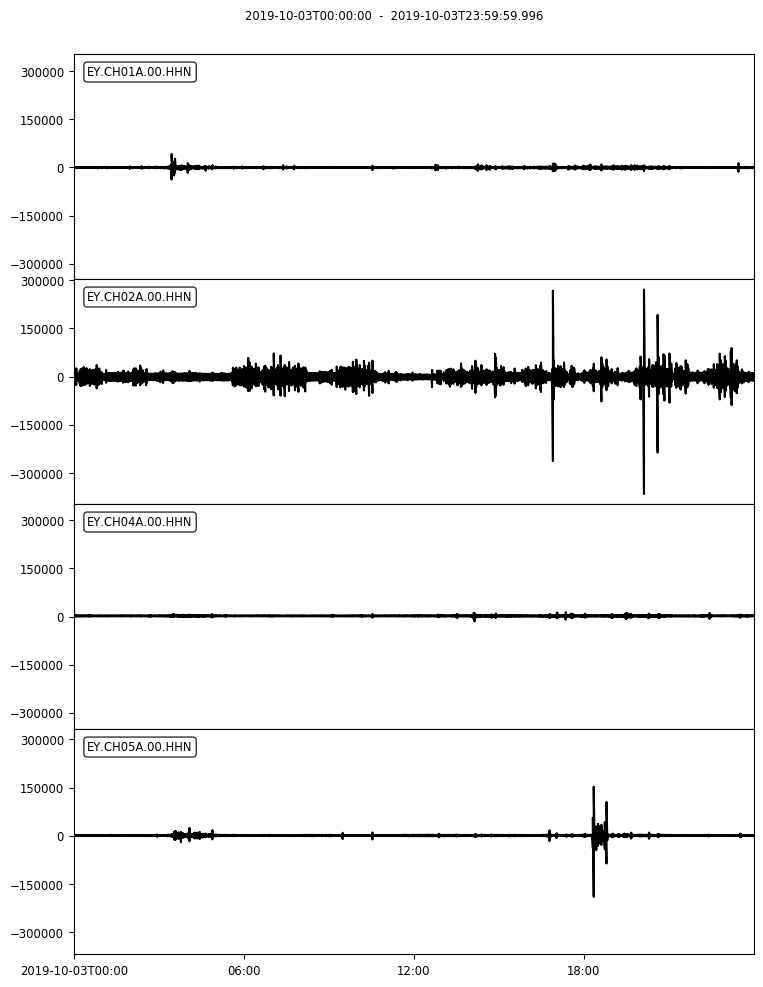

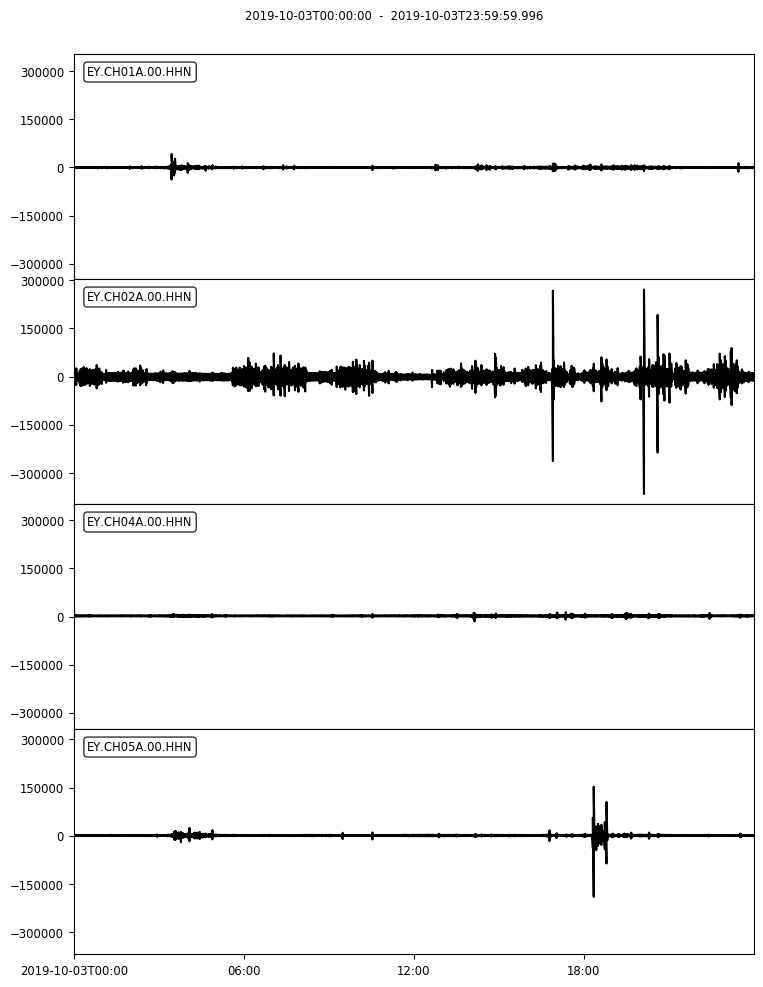

In [105]:
dt.plot()

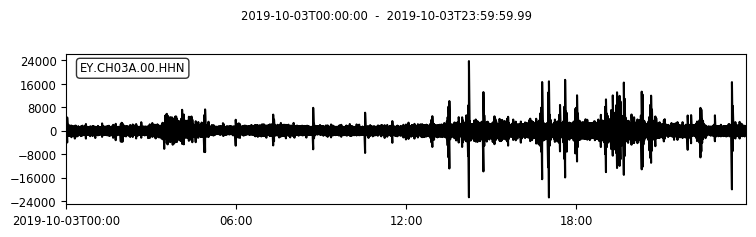

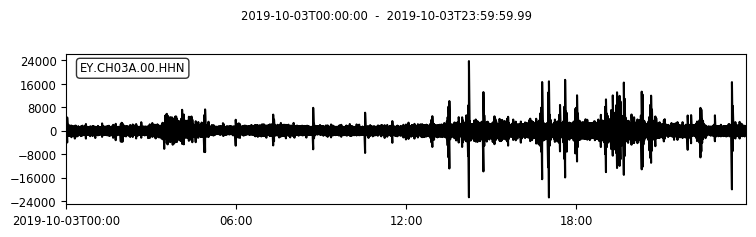

In [106]:
d3.plot()

## Neural kriging with/without physics

In [182]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X = np.array([dt[0].data.tolist(),dt[1].data.tolist(),dt[3].data.tolist()]).T
Y = dt[2].data.reshape(len(dt[2].data),1)
m, n = X.shape

X_train = X[0:int(m*0.6),:]
Y_train = Y[0:int(m*0.6)]
X_test = X[int(m*0.6):,:]
Y_test = Y[int(m*0.6):]

regr = MLPRegressor(max_iter=500).fit(X_train, Y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
Y_pred = regr.predict(X_test)
xx = [12+(i+1)/180000 for i in range(len(Y_test))]
plt.plot(xx, Y_test, label='truth')
plt.plot(xx, Y_pred, label='prediction')
plt.xlabel('Time, hr')
plt.ylabel('Seismic signal')
plt.legend()
plt.show()

In [3]:
x = [(i+1)/360000 for i in range(len(dt[2].data))]

In [4]:
plt.plot(x[int(len(x)/2):], dt[2].data[int(len(x)/2):], label='truth')
plt.plot(x[int(len(x)/2):], d3_pred1[int(len(x)/2):], label='prediction')
plt.xlabel('Time, hr')
plt.ylabel('Seismic signal')
plt.legend()
plt.show()

NameError: name 'plt' is not defined